In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scanpy as sc
import pytorch_lightning as pl
import yaml

from lab_scripts.utils import utils
utils.change_directory_to_repo()

from lab_scripts.data import dataloader
from lab_scripts.mains.mp import common, main, preprocessing
from lab_scripts.models import mp

In [2]:
with open('configs/mp/mp/gex_to_adt.yaml', 'r') as f:
    config =yaml.safe_load(f)

In [3]:
data_config = config['data']
model_config = config['model']
dataset = dataloader.load_data(
    data_config["dataset_name"],
    val_size=data_config["val_size"],
    filter_genes=(data_config["gene_fraction"], "data/genes.csv"),
)

-1.3947728872299194


In [4]:
preprocessed_data = preprocessing.preprocess_data(
    data_config, dataset, model_config["batch_size"], is_train=False
)

In [5]:
train_dataloader = preprocessed_data["train_dataloader"]
test_dataloader = preprocessed_data['test_dataloader']
model_config = common.update_model_config(model_config, preprocessed_data)

[0.77718379 0.72864876 1.44627935 1.53971616]


In [6]:
model = mp.Predictor.load_from_checkpoint('checkpoints/mp/mp/gex_to_adt.ckpt', config=model_config)

In [7]:
trainer = pl.Trainer(gpus=1, logger=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
train_predictions = []
for i, batch in enumerate(train_dataloader):
    first, _, _ = batch
    prediction = model.predict_step(first, i).cpu()
    train_predictions.append(prediction)

In [9]:
test_predictions = []
for i, batch in enumerate(test_dataloader):
    first, _, _ = batch
    prediction = model.predict_step(first, i).cpu()
    test_predictions.append(prediction)

In [10]:
train_predictions = torch.cat(train_predictions, dim=0).detach()
test_predictions = torch.cat(test_predictions, dim=0).detach()


In [11]:
train_predictions.shape

torch.Size([29076, 134])

In [12]:
test_predictions.shape

torch.Size([1000, 134])

In [13]:
train_inversed = preprocessed_data['second_train_inverse'](train_predictions)
test_inversed = preprocessed_data['second_train_inverse'](test_predictions)

In [14]:
dataset['train_mod2'].shape

(29076, 134)

In [15]:
train_inversed.shape

(29076, 134)

In [23]:
train_error = (dataset['train_mod2'].X.toarray() - train_inversed)**2

In [24]:
train_error = train_error.mean(axis=1)

In [27]:
test_error = (dataset['test_mod2'].X.toarray() - test_inversed)**2

In [28]:
test_error = test_error.mean(axis=1)

In [29]:
common_data = ad.read_h5ad('data/official/common/openproblems_bmmc_cite_phase1/openproblems_bmmc_cite_phase1.manual_formatting.output_rna.h5ad')

In [32]:
dataset['train_mod2'].obs['error'] = train_error

Trying to set attribute `.obs` of view, copying.


In [33]:
dataset['test_mod2'].obs['error'] = test_error

In [35]:
train_names = set(dataset['train_mod2'].obs.index)

In [50]:
common_train = common_data.obs.loc[train_names]

In [51]:
common_train

,n_genes_by_counts,pct_counts_mt,size_factors,phase,cell_type,pseudotime_order_GEX,batch,pseudotime_order_ADT,is_train
CTACTATTCAGACAAA-1-s3d6,991,5.773749,0.595354,G2M,Naive CD20+ B IGKC+,NaN,s3d6,NaN,True
GGTGAAGCAACGGCCT-1-s2d4,5030,5.295238,5.038833,G2M,cDC2,NaN,s2d4,NaN,True
CATTCCGTCCACGTAA-1-s2d1,1093,13.219831,0.645375,G2M,CD14+ Mono,NaN,s2d1,NaN,True
ACGATCAGTGAGACCA-1-s2d1,1535,8.755131,1.381448,G2M,CD14+ Mono,NaN,s2d1,NaN,True
GTAGTACGTGGTAACG-1-s2d1,811,10.875216,0.420653,G2M,CD8+ T naive,NaN,s2d1,NaN,True
...,...,...,...,...,...,...,...,...,...
TCATTCAGTCAGTCGC-1-s2d1,1477,6.463696,1.127068,G2M,Plasma cell IGKC+,NaN,s2d1,NaN,True
CATAGACAGAAGCCAC-1-s2d1,1374,4.017400,1.004874,S,pDC,NaN,s2d1,NaN,True
TACAGGTAGCCTGGAA-1-s2d1,1600,9.693594,1.292868,G2M,CD14+ Mono,NaN,s2d1,NaN,True
TCTGGCTGTCCATAGT-1-s3d6,2697,9.870861,2.156510,S,G/M prog,NaN,s3d6,NaN,True


In [52]:
common_train['error'] = train_error

In [53]:
test_names = set(dataset['test_mod2'].obs.index)
common_test = common_data.obs.loc[test_names]

In [55]:
common_test['error'] = test_error

In [85]:
common_train.groupby(['cell_type']).mean()['error'].sort_values(ascending=False)

cell_type
gdT TCRVD2+                         0.103369
CD8+ T CD57+ CD45RO+                0.100679
ILC1                                0.100366
T reg                               0.098807
MK/E prog                           0.098627
cDC2                                0.098316
CD8+ T TIGIT+ CD45RO+               0.098117
Normoblast                          0.097912
ILC                                 0.097911
Erythroblast                        0.097834
Naive CD20+ B IGKC-                 0.097499
Reticulocyte                        0.097497
CD8+ T CD57+ CD45RA+                0.096963
Plasmablast IGKC+                   0.096794
CD8+ T CD69+ CD45RA+                0.096761
CD16+ Mono                          0.096656
Proerythroblast                     0.096516
CD8+ T naive                        0.096502
Naive CD20+ B IGKC+                 0.096497
CD8+ T TIGIT+ CD45RA+               0.096470
CD4+ T activated                    0.096387
CD14+ Mono                          0.096333


In [78]:
common_train

,n_genes_by_counts,pct_counts_mt,size_factors,phase,cell_type,pseudotime_order_GEX,batch,pseudotime_order_ADT,is_train,error
CTACTATTCAGACAAA-1-s3d6,991,5.773749,0.595354,G2M,Naive CD20+ B IGKC+,NaN,s3d6,NaN,True,0.125839
GGTGAAGCAACGGCCT-1-s2d4,5030,5.295238,5.038833,G2M,cDC2,NaN,s2d4,NaN,True,0.077324
CATTCCGTCCACGTAA-1-s2d1,1093,13.219831,0.645375,G2M,CD14+ Mono,NaN,s2d1,NaN,True,0.107221
ACGATCAGTGAGACCA-1-s2d1,1535,8.755131,1.381448,G2M,CD14+ Mono,NaN,s2d1,NaN,True,0.064224
GTAGTACGTGGTAACG-1-s2d1,811,10.875216,0.420653,G2M,CD8+ T naive,NaN,s2d1,NaN,True,0.083815
...,...,...,...,...,...,...,...,...,...,...
TCATTCAGTCAGTCGC-1-s2d1,1477,6.463696,1.127068,G2M,Plasma cell IGKC+,NaN,s2d1,NaN,True,0.092654
CATAGACAGAAGCCAC-1-s2d1,1374,4.017400,1.004874,S,pDC,NaN,s2d1,NaN,True,0.085936
TACAGGTAGCCTGGAA-1-s2d1,1600,9.693594,1.292868,G2M,CD14+ Mono,NaN,s2d1,NaN,True,0.081339
TCTGGCTGTCCATAGT-1-s3d6,2697,9.870861,2.156510,S,G/M prog,NaN,s3d6,NaN,True,0.080892


In [84]:
common_test.groupby(['cell_type']).mean()['error'].sort_values(ascending=False)

cell_type
Naive CD20+ B IGKC+                 0.400538
gdT TCRVD2+                         0.369241
T reg                               0.360674
Plasma cell IGKC+                   0.353652
CD4+ T activated integrinB7+        0.352352
B1 B IGKC-                          0.351420
CD8+ T naive CD127+ CD26- CD101-    0.341787
CD4+ T CD314+ CD45RA+               0.335432
CD8+ T CD49f+                       0.334932
B1 B IGKC+                          0.333384
HSC                                 0.331630
NK CD158e1+                         0.331544
ILC1                                0.331075
CD8+ T TIGIT+ CD45RO+               0.330209
cDC2                                0.325384
CD4+ T activated                    0.323121
MAIT                                0.320211
CD14+ Mono                          0.320064
Naive CD20+ B IGKC-                 0.317276
Lymph prog                          0.316022
CD8+ T CD57+ CD45RA+                0.313115
G/M prog                            0.310430


In [90]:
common_train.groupby(['batch', 'cell_type']).mean()['error']

batch  cell_type                   
s1d1   B1 B IGKC+                      0.095102
       B1 B IGKC-                      0.084967
       CD4+ T CD314+ CD45RA+                NaN
       CD4+ T activated                0.095303
       CD4+ T activated integrinB7+    0.102362
                                         ...   
s3d7   cDC2                                 NaN
       dnT                                  NaN
       gdT CD158b+                          NaN
       gdT TCRVD2+                          NaN
       pDC                                  NaN
Name: error, Length: 270, dtype: float32

In [93]:
common_train['batch'].value_counts()

s3d6    9976
s2d1    9353
s2d4    5026
s1d1    4721
s1d2       0
s3d7       0
Name: batch, dtype: int64

In [114]:
one_type_train = common_train[common_train['cell_type'] == 'NK']

(array([ 1.,  4.,  9.,  8., 16., 20., 16., 25., 37., 38., 41., 46., 52.,
        41., 45., 53., 46., 41., 41., 44., 25., 25., 13., 17., 16.,  3.,
         5., 11., 13., 10.,  4.,  4.,  2.,  3.,  2.,  3.,  3.,  1.,  1.,
         0.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.0268571 , 0.03128082, 0.03570455, 0.04012828, 0.044552  ,
        0.04897573, 0.05339945, 0.05782318, 0.06224691, 0.06667063,
        0.07109436, 0.07551809, 0.07994181, 0.08436554, 0.08878926,
        0.09321299, 0.09763671, 0.10206044, 0.10648417, 0.1109079 ,
        0.11533162, 0.11975535, 0.12417907, 0.1286028 , 0.13302653,
        0.13745025, 0.14187397, 0.14629771, 0.15072143, 0.15514515,
        0.15956888, 0.16399261, 0.16841634, 0.17284006, 0.17726378,
        0.18168752, 0.18611124, 0.19053496, 0.19495869, 0.19938241,
        0.20380615, 0.20822987, 0.21265359, 0.21707731, 0.22150105,
        0.22592478, 0.2303485 , 0.23477222, 0.23919596, 0.24361968,
        0.2480434 ], dtype=float32),

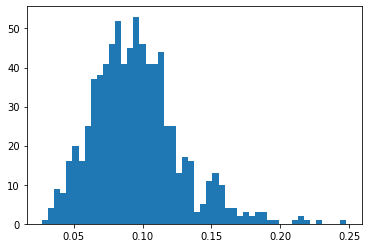

In [115]:
plt.hist(one_type_train['error'], bins=50)

In [118]:
one_type_test = common_test[common_test['cell_type'] == 'CD8+ T naive']

(array([2., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 3., 0., 1., 1., 1., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]),
 array([0.11061262, 0.11758145, 0.12455027, 0.1315191 , 0.13848792,
        0.14545675, 0.15242557, 0.15939438, 0.16636321, 0.17333204,
        0.18030086, 0.18726969, 0.19423851, 0.20120734, 0.20817615,
        0.21514498, 0.2221138 , 0.22908263, 0.23605146, 0.24302028,
        0.24998909, 0.25695792, 0.26392674, 0.27089557, 0.2778644 ,
        0.28483322, 0.29180205, 0.29877087, 0.3057397 , 0.31270853,
        0.31967735, 0.32664615, 0.33361498, 0.3405838 , 0.34755263,
        0.35452145, 0.36149028, 0.3684591 , 0.37542793, 0.38239676,
        0.38936558, 0.3963344 , 0.40330324, 0.41027206, 0.41724086,
        0.42420968, 0.4311785 , 0.43814734, 0.44511616, 0.452085  ,
        0.4590538 ], dtype=float32),
 <BarContainer object of 50 artists>)

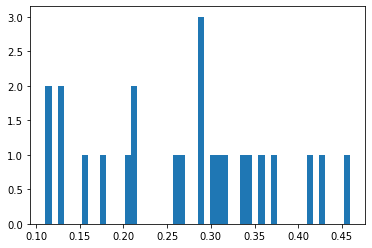

In [119]:
plt.hist(one_type_test['error'], bins=50)